<b>Домашнее задание:</b> Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Для сбора предсказаний можно использовать ту же функцию predict что и для бустинга на деревьях<br>
<i>Примечания: в LogLoss необходимо передавать не предсказания полученные с помощью clf.predict(...), а вероятность, полученную с помощью clf.predict_proba(...)[:, 1]  

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn import model_selection
import numpy as np

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

#LogLoss
def log_loss(pred, y):
    return -np.sum(y*np.log(pred)+(1-y)*np.log(1-pred))/len(y)

def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [3]:
# адаптивный бустинг с логистической регрессией
def adaboost_lr(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # логисстическая модель
        clf = LogisticRegression()
        clf.fit(X, y, w)

        predictions = clf.predict_proba(X)[:, 1]
        e = log_loss(predictions, y)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим модель с весом в список
        models.append((alpha, clf))
    
    return models

In [4]:
# адаптивный бустинг дерево решений
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth  =1)
        clf.fit(X, y, w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [5]:
N = 50
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    models = adaboost(X_train, y_train, N) # дерово решение
    models1 = adaboost_lr(X_train, y_train, N) #линейная регрессия

In [6]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность дер. решений на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность лин. регрессии на обучающей выборке: {(1 - get_error(predict(X_train, models1), y_train)) * 100:.3f}')

Точность дер. решений на обучающей выборке: 97.183
Точность лин. регрессии на обучающей выборке: 93.427


In [7]:
print(f'Точность дер. решений на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')
print(f'Точность лин. регрессии на тестовой выборке: {(1 - get_error(predict(X_test, models1), y_test)) * 100:.3f}')

Точность дер. решений на тестовой выборке: 93.706
Точность лин. регрессии на тестовой выборке: 93.007


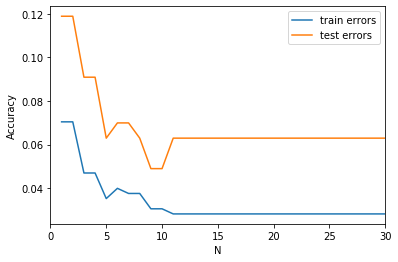

In [8]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

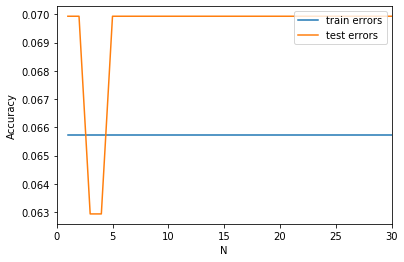

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_errors = []
    test_errors = []

    for n in range(1, 31):
        mods = adaboost_lr(X_train, y_train, n)
        train_errors.append(get_error(predict(X_train, mods), y_train))
        test_errors.append(get_error(predict(X_test, mods), y_test))
    x = list(range(1, 31))

    plt.xlim(0, 30)
    plt.plot(x, train_errors, label='train errors')
    plt.plot(x, test_errors, label='test errors')
    plt.xlabel('N')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')

<b>Домашнее задание(необязательное, повышенной сложности):</b> Реализовать специальную функцию predict для бустинга на логистической регрессии выводящую предсказания по формуле: $ Predictions=sign(Score_{bust}) $,
где sign равен единице для положительных и нулю для отрицательных значений, а $ Score_{bust}= \sum \alpha_iScore_i$. Баллы выдаваемые каждой моделью $Score_i$ можно найти при помощи вызова метода decision_function на моделе

In [26]:
def predict_lr(X, models):
    score_bust=[]
    for alpha, clf in models:
        score_bust.append(np.sum(clf.decision_function(X)*alpha))
        
    return 1+np.sign(score_bust)

In [27]:
predict_lr(X_train, models1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
predict_lr(X_test, models1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])